# Dimensionality Reduction Using Keras Autoencoder

An autoencoder can be used for dimensionality reduction when there are too many features in dataset. This kind of autoencoders is an undercomplete autoencoder $-$ The size of hidden layer is smaller than the input layer. By reducing the hidden layer size or the numer of nuerons, we force the network to learn the important features of the dataset.

Autoencoders are is a neural network used to learn efficient data patterns in an unsupervised manner. An autoencoder ideally consists of an encoder and a decoder. The encoder is designed compress data, whereas the decoder will try to uncompress the data. The illustration of an autoencoder workflow is (credit from [Niyas Mohammed: How to autoencode your Pokémon](https://hackernoon.com/how-to-autoencode-your-pokémon-6b0f5c7b7d97))
 
![title](img/autoencoder.png)

The original neural network (supervised) models work as 

$$\textrm{model.fit(X, y)}$$

But an autocorder works as

$$\textrm{model.fit(X, X)}$$

Other than the input and output layer, the first half hidden layers are encoders, and second half are decoders.

The first part of this note follows the [Keras blog](https://blog.keras.io/building-autoencoders-in-keras.html), and the second part follows the blog solution given by [Varun Kruthiventi, Dimensionality reduction using Keras Auto Encoder](https://www.kaggle.com/saivarunk/dimensionality-reduction-using-keras-auto-encoder).

### Reference

* [Keras blog: Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
* [Varun Kruthiventi, Dimensionality reduction using Keras Auto Encoder](https://www.kaggle.com/saivarunk/dimensionality-reduction-using-keras-auto-encoder)
* [Niyas Mohammed: How to autoencode your Pokémon](https://hackernoon.com/how-to-autoencode-your-pokémon-6b0f5c7b7d97)
* Pyspark code: [Dimension Reduction - Autoencoders](https://blog.paperspace.com/dimension-reduction-with-autoencoders/)

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1. Compress MNIST digits image

First example uses the MNIST data. We follow the [Keras blog](https://blog.keras.io/building-autoencoders-in-keras.html).

In [39]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, _), (x_test, _) = mnist.load_data()

In [41]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [54]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


### Using autoencoder to reduce dimension from 28x28D to 32D

In [52]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
mnist_autoencoder = Model(input_img, decoded)

mnist_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [53]:
mnist_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_20 (Dense)             (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


The separate encoder/decoder models are

In [45]:
mnist_autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.3629 - val_loss: 0.2708
Epoch 2/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.2629 - val_loss: 0.2509
Epoch 3/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.2404 - val_loss: 0.2280
Epoch 4/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.2207 - val_loss: 0.2111
Epoch 5/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.2061 - val_loss: 0.1986
Epoch 6/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.1951 - val_loss: 0.1891
Epoch 7/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.1866 - val_loss: 0.1814
Epoch 8/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.1796 - val_loss: 0.1751
Epoch 9/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.1737 - val_loss: 0.1696
Epoch

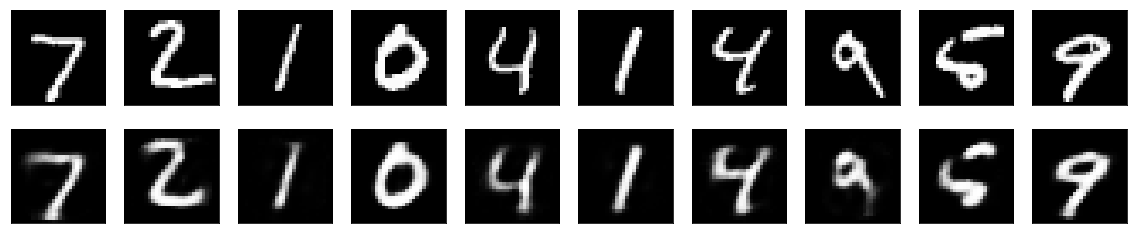

In [46]:
# build an encoded model maps an input
mnist_encoder = Model(input_img, encoded)

# -------------------------------------------------

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = mnist_autoencoder.layers[-1]
# create the decoder model
mnist_decoder = Model(encoded_input, decoder_layer(encoded_input))

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = mnist_encoder.predict(x_test)
decoded_imgs = mnist_decoder.predict(encoded_imgs)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### More compression, reduce to 10D

In [48]:
# this is the size of our encoded representations
encoding_dim = 10  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

mnist_autoencoder = Model(input_img, decoded)
mnist_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [51]:
mnist_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                7850      
_________________________________________________________________
dense_18 (Dense)             (None, 784)               8624      
Total params: 16,474
Trainable params: 16,474
Non-trainable params: 0
_________________________________________________________________


In [49]:
mnist_autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.3713 - val_loss: 0.2720
Epoch 2/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.2652 - val_loss: 0.2548
Epoch 3/50
60000/60000 [==============================] - 2s 25us/step - loss: 0.2458 - val_loss: 0.2348
Epoch 4/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.2284 - val_loss: 0.2195
Epoch 5/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.2151 - val_loss: 0.2082
Epoch 6/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.2056 - val_loss: 0.2006
Epoch 7/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.1989 - val_loss: 0.1948
Epoch 8/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1941 - val_loss: 0.1907
Epoch 9/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.1905 - val_loss: 0.1877
Epoch

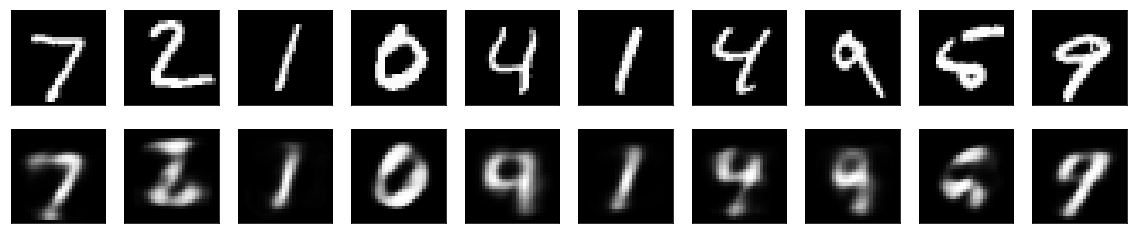

In [50]:
mnist_encoder = Model(input_img, encoded)

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = mnist_autoencoder.layers[-1]
mnist_decoder = Model(encoded_input, decoder_layer(encoded_input))

encoded_imgs = mnist_encoder.predict(x_test)
decoded_imgs = mnist_decoder.predict(encoded_imgs)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Of course, with less neurons, the decoded images have less resolution since most information are thrown away. Therefore we saw the latter case the images look less clearly.

# 2. Kaggle Competition Dataset

Second example builds an autoencoder using on [Kaggle competition](https://www.kaggle.com/saivarunk/dimensionality-reduction-using-keras-auto-encoder).

In [55]:
print(os.listdir("data"))

['test.csv', 'train.csv', 'sample_submission.csv']


In [56]:
train_data, test_data = pd.read_csv('data/train.csv'), pd.read_csv('data/test.csv')

In [57]:
train_data.shape, test_data.shape

((4459, 4993), (49342, 4992))

In [59]:
train_data.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [60]:
test_data.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
train_target = train_data['target']
train_id, test_id = train_data['ID'], test_data['ID']

train_data.drop(['target', 'ID'], axis=1, inplace=True)
test_data.drop(['ID'], axis=1, inplace=True)

In [62]:
train_scaled, test_scaled = minmax_scale(train_data, axis = 0), minmax_scale(test_data, axis = 0)

### Split train data into train and validation

In [63]:
X_train, X_test, _, _ = train_test_split(train_scaled, train_target, train_size = 0.8, random_state = seed(2017))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [69]:
X_train.shape

(3567, 4991)

In [64]:
### Define the encoder dimension
encoding_dim = 200

# define the number of features
ncol = train_scaled.shape[1]

### Deep autoencoder

We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers. There are sixe hidden layers for both encoder and decoder, respectively. We use `relu` as activation function. The goal is reduce the 

In [66]:
input_dim = Input(shape = (ncol, ))

# Encoder Layers
encoded1 = Dense(3000, activation = 'relu')(input_dim)
encoded2 = Dense(2000, activation = 'relu')(encoded1)
encoded3 = Dense(1000, activation = 'relu')(encoded2)
encoded4 = Dense(500, activation = 'relu')(encoded3)
encoded5 = Dense(250, activation = 'relu')(encoded4)
encoded6 = Dense(encoding_dim, activation = 'relu')(encoded5)

# Decoder Layers
decoded1 = Dense(250, activation = 'relu')(encoded6)
decoded2 = Dense(500, activation = 'relu')(decoded1)
decoded3 = Dense(1000, activation = 'relu')(decoded2)
decoded4 = Dense(2000, activation = 'relu')(decoded3)
decoded5 = Dense(3000, activation = 'relu')(decoded4)
decoded6 = Dense(ncol, activation = 'sigmoid')(decoded5)

# Combine Encoder and Deocder layers
autoencoder = Model(inputs = input_dim, outputs = decoded6)

# Compile the Model
autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')

In [67]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 4991)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 3000)              14976000  
_________________________________________________________________
dense_34 (Dense)             (None, 2000)              6002000   
_________________________________________________________________
dense_35 (Dense)             (None, 1000)              2001000   
_________________________________________________________________
dense_36 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_37 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_38 (Dense)             (None, 200)               50200     
__________

In [68]:
autoencoder.fit(X_train, X_train, nb_epoch = 10, batch_size = 32, shuffle = False, validation_data = (X_test, X_test))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 3567 samples, validate on 892 samples
Epoch 1/10
3567/3567 [==============================] - 82s 23ms/step - loss: 0.6881 - val_loss: 0.6794
Epoch 2/10
3567/3567 [==============================] - 78s 22ms/step - loss: 0.2264 - val_loss: 0.0170
Epoch 3/10
3567/3567 [==============================] - 91s 25ms/step - loss: 0.0142 - val_loss: 0.0150
Epoch 4/10
3567/3567 [==============================] - 83s 23ms/step - loss: 0.0135 - val_loss: 0.0148
Epoch 5/10
3567/3567 [==============================] - 88s 25ms/step - loss: 0.0133 - val_loss: 0.0147
Epoch 6/10
3567/3567 [==============================] - 83s 23ms/step - loss: 0.0133 - val_loss: 0.0147
Epoch 7/10
3567/3567 [==============================] - 83s 23ms/step - loss: 0.0133 - val_loss: 0.0147
Epoch 8/10
3567/3567 [==============================] - 84s 24ms/step - loss: 0.0132 - val_loss: 0.0147
Epoch 9/10
3567/3567 [==============================] - 76s 21ms/step - loss: 0.0132 - val_loss: 0.0146
Epoch 10/10
3567/

### Encoder Model

Encoder model reduces the input data from 4491-D to 200-D.

In [70]:
encoder = Model(inputs = input_dim, outputs = encoded6)

In [77]:
encoded_train = pd.DataFrame(encoder.predict(train_scaled))
encoded_train = encoded_train.add_prefix('feature_')

encoded_test = pd.DataFrame(encoder.predict(test_scaled))
encoded_test = encoded_test.add_prefix('feature_')

encoded_train.shape, encoded_test.shape

((4459, 200), (49342, 200))

In [78]:
encoded_train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_190,feature_191,feature_192,feature_193,feature_194,feature_195,feature_196,feature_197,feature_198,feature_199
0,0.0,0.309469,0.263464,0.0,0.922860,0.260930,1.380339,0.147479,0.0,0.0,...,1.193345,0.0,0.227130,0.869521,0.0,0.000000,0.827230,0.0,0.0,0.897443
1,0.0,0.309292,0.266113,0.0,0.958097,0.252851,1.410948,0.158832,0.0,0.0,...,1.224509,0.0,0.244537,0.901667,0.0,0.000000,0.858660,0.0,0.0,0.923805
2,0.0,0.342343,0.303822,0.0,1.076818,0.288477,1.610620,0.175176,0.0,0.0,...,1.387827,0.0,0.283699,0.999637,0.0,0.000000,0.967655,0.0,0.0,1.035747
3,0.0,0.341094,0.305089,0.0,1.082210,0.289272,1.618329,0.172437,0.0,0.0,...,1.396970,0.0,0.286716,1.005485,0.0,0.000172,0.973439,0.0,0.0,1.037651
4,0.0,0.331109,0.282797,0.0,1.015164,0.278817,1.515709,0.161408,0.0,0.0,...,1.319425,0.0,0.262728,0.950523,0.0,0.000000,0.917778,0.0,0.0,0.979254


### Decoder Model

Decoder model is used to recover the compressed data (mean the input data be compressed, 200D) back to one with original dimensionaltiy (4991D). The output data will be different from the original data, due to truncation on encoder. The construction of the decoder model is pretty trick, not simply using `decoder = Model(encoded_input, decoder_layer(encoded_input))}.` We need to iterate layer. Check [here](https://stackoverflow.com/questions/37758496/python-keras-theano-wrong-dimensions-for-deep-autoencoder/37765621#37765621).

In [74]:
encoded_input = Input(shape = (encoding_dim, ))

decoder_layer = autoencoder.layers[-1]

num_decoder_layers = 6
decoder_layer = encoded_input
for i in range(-num_decoder_layers, 0):
    decoder_layer = autoencoder.layers[i](decoder_layer)

decoder = Model(input=encoded_input, output=decoder_layer)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


In [79]:
decoded_test = pd.DataFrame(decoder.predict(encoded_test))
decoded_test = decoded_test.add_prefix('feature_')

decoded_test.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_4981,feature_4982,feature_4983,feature_4984,feature_4985,feature_4986,feature_4987,feature_4988,feature_4989,feature_4990
0,0.000457,0.000167,0.000668,0.000050,0.000146,0.000635,0.000047,0.000202,0.006324,0.002468,...,0.003349,0.002855,0.005575,0.002816,0.000132,0.000071,0.000098,0.001093,0.000747,0.002489
1,0.000056,0.000015,0.000091,0.000003,0.000013,0.000085,0.000003,0.000020,0.001598,0.000480,...,0.000710,0.000579,0.001366,0.000569,0.000011,0.000005,0.000008,0.000170,0.000104,0.000486
2,0.000081,0.000023,0.000129,0.000005,0.000020,0.000121,0.000005,0.000030,0.002034,0.000640,...,0.000932,0.000766,0.001748,0.000753,0.000018,0.000008,0.000012,0.000235,0.000147,0.000647
3,0.000149,0.000047,0.000230,0.000012,0.000040,0.000217,0.000011,0.000058,0.003037,0.001031,...,0.001465,0.001219,0.002634,0.001200,0.000036,0.000018,0.000026,0.000405,0.000261,0.001042
4,0.000133,0.000041,0.000207,0.000010,0.000035,0.000195,0.000010,0.000052,0.002822,0.000944,...,0.001349,0.001120,0.002445,0.001102,0.000032,0.000015,0.000022,0.000367,0.000235,0.000955


To verify our application on encoder and decoder is correct, we can implement the autoencoder to generate the recover data and compare:

In [80]:
autoencoded_test = pd.DataFrame(autoencoder.predict(test_scaled))
autoencoded_test.head()

,0,1,2,3,4,5,6,7,8,9,...,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990
0,0.000457,0.000167,0.000668,0.000050,0.000146,0.000635,0.000047,0.000202,0.006324,0.002468,...,0.003349,0.002855,0.005575,0.002816,0.000132,0.000071,0.000098,0.001093,0.000747,0.002489
1,0.000056,0.000015,0.000091,0.000003,0.000013,0.000085,0.000003,0.000020,0.001598,0.000480,...,0.000710,0.000579,0.001366,0.000569,0.000011,0.000005,0.000008,0.000170,0.000104,0.000486
2,0.000081,0.000023,0.000129,0.000005,0.000020,0.000121,0.000005,0.000030,0.002034,0.000640,...,0.000932,0.000766,0.001748,0.000753,0.000018,0.000008,0.000012,0.000235,0.000147,0.000647
3,0.000149,0.000047,0.000230,0.000012,0.000040,0.000217,0.000011,0.000058,0.003037,0.001031,...,0.001465,0.001219,0.002634,0.001200,0.000036,0.000018,0.000026,0.000405,0.000261,0.001042
4,0.000133,0.000041,0.000207,0.000010,0.000035,0.000195,0.000010,0.000052,0.002822,0.000944,...,0.001349,0.001120,0.002445,0.001102,0.000032,0.000015,0.000022,0.000367,0.000235,0.000955
